In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 15 01:41:26 2022

@author: timyu
"""

import numpy as np
import datetime as dt
import pandas as pd
import scipy.optimize as sc
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import time

from pandas_datareader import data as pdr

def getData(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start=start, end=end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix


def portfolioPerformance(weights, meanReturns, covMatrix):
    returns = np.sum(meanReturns*weights)*252
    std = np.sqrt(np.dot(weights.T,np.dot(covMatrix, weights)))*np.sqrt(252)
    return returns, std


def negativeSR(weights, meanReturns, covMatrix, riskFreeRate = 0):
    pReturns, pStd = portfolioPerformance(weights, meanReturns, covMatrix)
    return - (pReturns - riskFreeRate)/pStd

def maxSR(meanReturns, covMatrix, riskFreeRate = 0, constraintSet=(0,1)):
    "Minimize the negative SR, by altering the weights of the portfolio"
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(negativeSR, numAssets*[1./numAssets], args=args,
                         method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolioVariance(weights, meanReturns, covMatrix):
    return portfolioPerformance(weights, meanReturns, covMatrix)[1]
def minimizeVariance(meanReturns, covMatrix, constraintSet=(0,1)):
    """Minimize the portfolio variance by altering the 
     weights/allocation of assets in the portfolio"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(portfolioVariance, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolioReturn(weights, meanReturns, covMatrix):
        return portfolioPerformance(weights, meanReturns, covMatrix)[0]

def efficientOpt(meanReturns, covMatrix, returnTarget, constraintSet=(0,1)):
    """For each returnTarget, we want to optimise the portfolio for min variance"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type':'eq', 'fun': lambda x: portfolioReturn(x, meanReturns, covMatrix) - returnTarget},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    effOpt = sc.minimize(portfolioVariance, numAssets*[1./numAssets], args=args, method = 'SLSQP', bounds=bounds, constraints=constraints)
    return effOpt


def calculatedResults(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(0,1)):
    """Read in mean, cov matrix, and other financial information
        Output, Max SR , Min Volatility, efficient frontier """
    # Max Sharpe Ratio Portfolio
    maxSR_Portfolio = maxSR(meanReturns, covMatrix)
    maxSR_returns, maxSR_std = portfolioPerformance(maxSR_Portfolio['x'], meanReturns, covMatrix)
    maxSR_allocation = pd.DataFrame(maxSR_Portfolio['x'], index=meanReturns.index, columns=['allocation'])
    maxSR_allocation.allocation = [round(i*100,0) for i in maxSR_allocation.allocation]
    
    # Min Volatility Portfolio
    minVol_Portfolio = minimizeVariance(meanReturns, covMatrix)
    minVol_returns, minVol_std = portfolioPerformance(minVol_Portfolio['x'], meanReturns, covMatrix)
    minVol_allocation = pd.DataFrame(minVol_Portfolio['x'], index=meanReturns.index, columns=['allocation'])
    minVol_allocation.allocation = [round(i*100,0) for i in minVol_allocation.allocation]
    
    # Efficient Frontier
    efficientList = []
    targetReturns = np.linspace(minVol_returns, maxSR_returns, 20)
    for target in targetReturns:
        efficientList.append(efficientOpt(meanReturns, covMatrix, target)['fun'])
        
    maxSR_returns, maxSR_std = round(maxSR_returns*100,2), round(maxSR_std*100,2)
    minVol_returns, minVol_std = round(minVol_returns*100,2), round(minVol_std*100,2)
    return maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList, targetReturns


def EF_graph(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(0,1)):
    """Return a graph ploting the min vol, max sr and efficient frontier"""
    maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList, targetReturns = calculatedResults(meanReturns, covMatrix, riskFreeRate, constraintSet)
    #Max SR
    MaxSharpeRatio = go.Scatter(
        name='Maximium Sharpe Ratio',
        mode='markers',
        x=[maxSR_std],
        y=[maxSR_returns],
        marker=dict(color='red',size=14,line=dict(width=3, color='black'))
    )
    #Min Vol
    MinVol = go.Scatter(
        name='Mininium Volatility',
        mode='markers',
        x=[minVol_std],
        y=[minVol_returns],
        marker=dict(color='green',size=14,line=dict(width=3, color='black'))
    )
    #Efficient Frontier
    EF_curve = go.Scatter(
        name='Efficient Frontier',
        mode='lines',
        x=[round(ef_std*100, 2) for ef_std in efficientList],
        y=[round(target*100, 2) for target in targetReturns],
        line=dict(color='black', width=4, dash='dashdot')
    )
    
    data = [MaxSharpeRatio, MinVol, EF_curve]
    layout = go.Layout(
        title = 'Portfolio Optimisation with the Efficient Frontier',
        yaxis = dict(title='Annualised Return (%)'),
        xaxis = dict(title='Annualised Volatility (%)'),
        showlegend = True,
        legend = dict(
            x = 0.75, y = 0, traceorder='normal',
            bgcolor='#E2E2E2',
            bordercolor='black',
            borderwidth=2),
        width=800,
        height=600)
    
    fig = go.Figure(data=data, layout=layout)
    return fig.show()




def rsltFun(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(0,1)):
    """Read in mean, cov matrix, and other financial information
        Output, Max SR , Min Volatility, efficient frontier """
    # Max Sharpe Ratio Portfolio
    maxSR_Portfolio = maxSR(meanReturns, covMatrix)
    maxSR_returns, maxSR_std = portfolioPerformance(maxSR_Portfolio['x'], meanReturns, covMatrix)
    maxSR_allocation = pd.DataFrame(maxSR_Portfolio['x'], index=meanReturns.index, columns=['allocation'])
    maxSR_allocation.allocation = [round(i*100,0) for i in maxSR_allocation.allocation]
    
    # Min Volatility Portfolio
    minVol_Portfolio = minimizeVariance(meanReturns, covMatrix)
    minVol_returns, minVol_std = portfolioPerformance(minVol_Portfolio['x'], meanReturns, covMatrix)
    minVol_allocation = pd.DataFrame(minVol_Portfolio['x'], index=meanReturns.index, columns=['allocation'])
    minVol_allocation.allocation = [round(i*100,0) for i in minVol_allocation.allocation]
    
    # Efficient Frontier
    efficientList = []
    targetReturns = np.linspace(minVol_returns, maxSR_returns, 20)
    for target in targetReturns:
        efficientList.append(efficientOpt(meanReturns, covMatrix, target)['fun'])
        
    maxSR_returns, maxSR_std = round(maxSR_returns*100,2), round(maxSR_std*100,2)
    minVol_returns, minVol_std = round(minVol_returns*100,2), round(minVol_std*100,2)
    rslt = [maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList, targetReturns, riskFreeRate]
    return rslt

def rsltOutput(rslt, startDate, endDate):
    """Return a graph ploting the min vol, max sr and efficient frontier"""
    maxSR_returns = rslt[0] 
    maxSR_std = rslt[1]
    maxSR_allocation = rslt[2]
    minVol_returns = rslt[3]
    minVol_std = rslt[4]
    minVol_allocation = rslt[5]
    riskFreeRate = rslt[8]
    
    maxSR_allocation = maxSR_allocation.T
    minVol_allocation = minVol_allocation.T
    
    allocation = pd.concat([maxSR_allocation, minVol_allocation])
    allocation.insert(0, "Portfolio Composition (%)", ["Max SR", "Min Vol"], True)
    
    info = pd.DataFrame({'Start Date': [startDate.strftime('%Y-%m-%d')],
                         'End Date': [endDate.strftime('%Y-%m-%d')],
                         'Risk Free Rate': [riskFreeRate]})
    
    returnVol = pd.DataFrame({'Portfolio': ["Max SR", "Min Vol"],
                              'Sharpe Ratio': [maxSR_returns/maxSR_std, minVol_returns/minVol_std],
                              'Returns (%)': [maxSR_returns, minVol_returns],
                              'Volatility (%)': [maxSR_std, minVol_std],})
    
    return(info, returnVol, allocation)


def EFPlot(meanReturns, covMatrix, rslt, startDate, endDate, country = "US"):
    """Return a graph ploting the min vol, max sr and efficient frontier"""
    maxSR_returns = rslt[0] 
    maxSR_std = rslt[1]
    minVol_returns = rslt[3]
    minVol_std = rslt[4]
    efficientList = rslt[6]
    targetReturns = rslt[7]
    riskFreeRate = rslt[8]
    
    stocks = list(meanReturns.index)
    
    returns = round(meanReturns*252*100, 2)
    std = np.round(np.sqrt(np.diag(covMatrix.values)*252)*100, 2)
    stockDf = pd.DataFrame({'Name': stocks,
                            'Returns': list(returns),
                            'Vol': list(std)})
    
    
    returnVol = pd.DataFrame({'Name': ["Max SR", "Min Vol"],
                              'Returns': [maxSR_returns, minVol_returns],
                              'Vol': [maxSR_std, minVol_std],})
    
    df_EF = pd.DataFrame({'Returns': [round(target*100, 2) for target in targetReturns],
                          'Vol': [round(ef_std*100, 2) for ef_std in efficientList]})
    
    
    plt.figure(figsize=(10,8))
    plt.title("Country: {}, Start Date: {}, End Date: {}, Risk Free Rate: {}".format(country,
                                                                                     startDate.strftime('%Y-%m-%d'),
                                                                                     endDate.strftime('%Y-%m-%d'),
                                                                                     riskFreeRate))
    plt.plot(df_EF['Vol'], df_EF['Returns'], 'k--', label="Efficient Frontier")
    plt.plot(returnVol['Vol'][0], returnVol['Returns'][0], 'go', label="Max Sharpe Ratio")
    plt.plot(returnVol['Vol'][1], returnVol['Returns'][1], 'co', label="Min Volatility")
    '''
    for i in range(len(returnVol)):
        plt.text(returnVol['Vol'][i], returnVol['Returns'][i], returnVol['Name'][i],
                 #bbox=dict(facecolor='blue', alpha=0.3),
                 horizontalalignment='left',
                 verticalalignment='bottom',
                 fontsize='small')
    '''
    plt.plot(stockDf['Vol'], stockDf['Returns'], 'bo')
    for i in range(len(stockDf)):
        plt.text(stockDf['Vol'][i], stockDf['Returns'][i], stockDf['Name'][i],
                 #bbox=dict(facecolor='blue', alpha=0.3),
                 horizontalalignment='left',
                 verticalalignment='bottom',
                 fontsize='medium')
    plt.legend()
    plt.xlabel("Annualized Volatility (%)")
    plt.ylabel("Annualized Return (%)")
    #tt = round(time.time())/1000
    #plt.savefig('EF_plot{}.jpg'.format(tt), dpi=200)
    
    return plt.show()

In [2]:
# 252 trading days per year 
days = 365*5
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=days)

In [3]:
stockList = ['GE', 'JPM', 'GOOG', 'AAPL', 'TSLA']
#stockList_US = ['GE', 'AAPL']
stocks = stockList

meanReturns, covMatrix = getData(stocks=stocks, start=startDate, end=endDate)
rslt = rsltFun(meanReturns, covMatrix, riskFreeRate=0.03, constraintSet=(0,1))

info, returnVol, allocation = rsltOutput(rslt, startDate, endDate)

In [4]:
print(info.to_string(index=False))

Start Date   End Date  Risk Free Rate
2017-11-20 2022-11-19            0.03


In [5]:
print(returnVol.to_string(index=False))

Portfolio  Sharpe Ratio  Returns (%)  Volotility (%)
   Max SR      1.115464        43.28           38.80
  Min Vol      0.632231        16.83           26.62


In [6]:
print(allocation.to_string(index=False))

Portfolio Composition (%)  GE  JPM  GOOG  AAPL  TSLA
                   Max SR 0.0  0.0   0.0  62.0  38.0
                  Min Vol 7.0 35.0  36.0  21.0   0.0


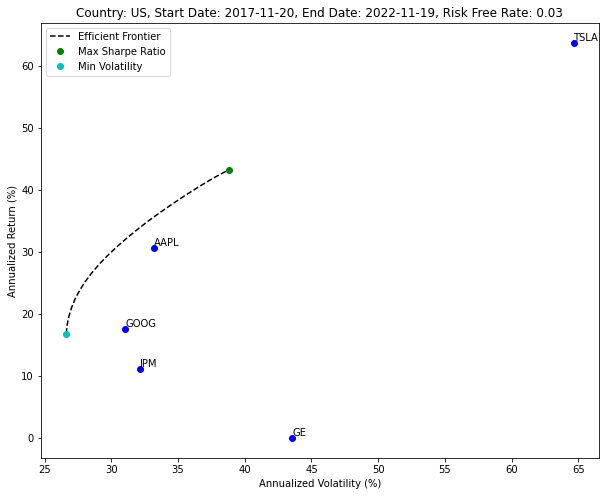

In [7]:
EFPlot(meanReturns, covMatrix, rslt, startDate, endDate, country="US")

In [8]:
stockList = ['510050', '510300', '510180', '512800', '512880']
#stockList_CN = ['510050', '512800']
stocks = [stock+'.SS' for stock in stockList]

meanReturns, covMatrix = getData(stocks=stocks, start=startDate, end=endDate)
rslt = rsltFun(meanReturns, covMatrix, riskFreeRate=0.03, constraintSet=(0,1))

info, returnVol, allocation = rsltOutput(rslt, startDate, endDate)

In [9]:
print(info.to_string(index=False))

Start Date   End Date  Risk Free Rate
2017-11-20 2022-11-19            0.03


In [10]:
print(returnVol.to_string(index=False))

Portfolio  Sharpe Ratio  Returns (%)  Volotility (%)
   Max SR      0.062595         1.24           19.81
  Min Vol      0.045599         0.86           18.86


In [11]:
print(allocation.to_string(index=False))

Portfolio Composition (%)  510050.SS  510300.SS  510180.SS  512800.SS  512880.SS
                   Max SR        0.0        0.0        0.0       98.0        2.0
                  Min Vol        0.0       19.0       26.0       56.0        0.0


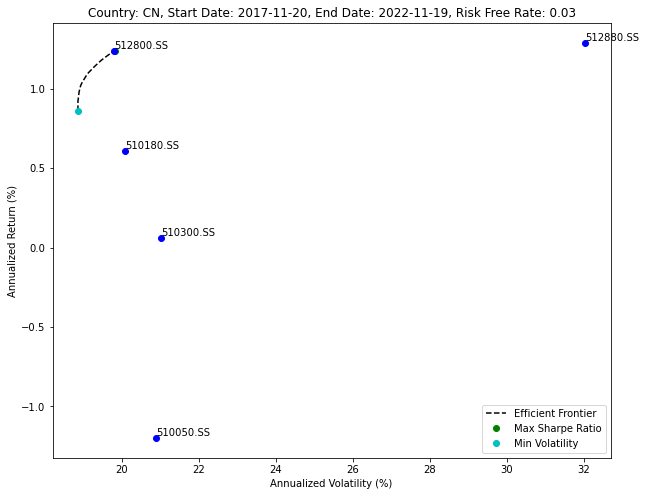

In [12]:
EFPlot(meanReturns, covMatrix, rslt, startDate, endDate, country="CN")